In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import cv2
import torch

import numpy as np
import matplotlib.pylab as plt
import torch.optim as optim
import torch.nn.functional as F

from models.VQVAE import VQVAE
from config import setSeed, getConfig
from customLoader import MinecraftData, LatentBlockDataset

from pprint import pprint
from os.path import join
from pathlib import Path

from torchvision.utils import make_grid
from torchvision.transforms import transforms

from torch.utils.data import DataLoader

In [3]:
conf = {
  "experiment": "test_2",
  "environment": "MineRLNavigate-v0",
  "batch_size": 256,
  "num_training_updates": 25000,
  "learning_rate": 0.001,
  "split": 0.9,
  "vqvae": {
    "num_hiddens": 128,
    "num_residual_hiddens": 32,
    "num_residual_layers": 2,
    "embedding_dim": 64,
    "num_embeddings": 512,
    "commitment_cost": 0.25,
    "decay": 0.99
  },
  "pixelcnn": {
    "epochs": 100,
    "save": "no",
    "log_interval": 100,
    "lr": 0.0003,
    "img_dim": 16,
    "batch_size": 32,
    "num_hiddens": 64,
    "num_layers": 15,
    "gen_samples": "no"
  }
}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
vqvae = VQVAE(**conf['vqvae']).to(device)

In [6]:
vqvae.eval()

VQVAE(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )


In [7]:
weights_vqvae = torch.load(f"../../weights/{conf['experiment']}/24999.pt")['state_dict']
vqvae.load_state_dict(weights_vqvae)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [9]:
transform = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                        ])


mrl_val = MinecraftData(conf['environment'], 'val', conf['split'], False, transform=transform, path='../../data')

validation_loader = DataLoader(mrl_val, batch_size=16, shuffle=True)

Loading data...


In [10]:
valid_originals = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

In [12]:
vq_output_eval = vqvae._pre_vq_conv(vqvae._encoder(valid_originals))
_, valid_quantize, _, encoding_indices = vqvae._vq_vae(vq_output_eval)

In [18]:
indices = torch.reshape(encoding_indices, (16,16,16)).unsqueeze(dim=3)

In [19]:
indices = indices.cpu().numpy()
indices.shape

(16, 16, 16, 1)

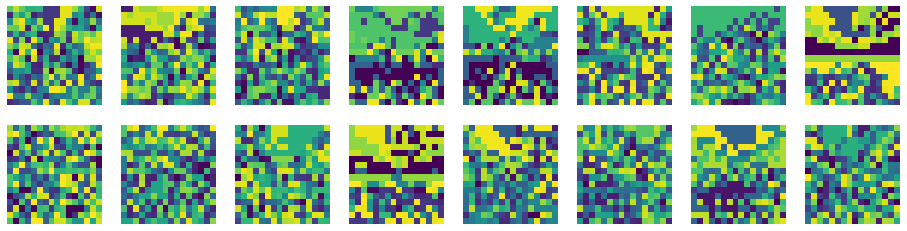

In [20]:
fig, ax = plt.subplots(2,8, figsize=(16,4))
for j,i in enumerate(indices):
    ax[int(j/8), int(j%8)].imshow(i)
    ax[int(j/8), int(j%8)].axis('off')
    ax[int(j/8), int(j%8)].axis("tight")
plt.show()
    

In [22]:
valid_reconstructions = vqvae._decoder(valid_quantize)
grid = make_grid(valid_reconstructions.cpu().data, normalize=True)

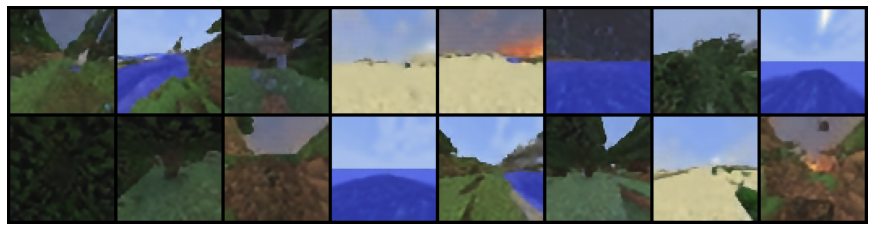

In [23]:
fig, ax = plt.subplots(figsize=(16,4))
plt.imshow(grid.permute(1,2,0).numpy())
plt.axis('off')
plt.show()